In [ ]:
print("Start - Load Dependencies...")
import csv
import gzip
import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import tarfile
import tensorflow as tf
import tempfile
import scipy.io
import shutil
from sklearn.preprocessing import OneHotEncoder
import random
import sys
import tensorflow as tf

from datetime import datetime

from IPython.display import display, Image

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from IPython.display import display, Image

import pandas as pd
from pandas import DataFrame, Series

from PIL import Image

from scipy import ndimage
from scipy.signal import convolve2d
from scipy.io import loadmat

from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

from sklearn.linear_model import LogisticRegression

from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
from tensorflow.examples.tutorials.mnist import input_data

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline
print("End - Load Dependencies...")

In [2]:
print("Start - Shared Functions...")
def create_directory(directory_name, print_debug=True):
    if not os.path.exists(directory_name):
        os.makedirs(directory_name)
        if (print_debug) == True:
            print('Created directory: ' +  directory_name)
    else:
        if (print_debug) == True:
            print('Directory: ' + directory_name + ' already exists - no need to create it')        
print("End - Shared Functions...")

Start - Shared Functions...
End - Shared Functions...


In [ ]:
print("Start - Extracting 32x32 svhn images...")

"""Helpers"""
last_percent_reported      = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
    
def has_expected_object_count(directory_name, expected_object_count):
  list = os.listdir(directory_name) 
  count = len(list)
  if expected_object_count == count :
     print ('Expected object count and actual object count match in: ' + directory_name)
     return True
  print ('No match of expect oject count:' +  str(expected_object_count)  + ' and file count: ' + str(count) + ' in directory: ' + directory_name)
  return False

def maybe_download(file_name, destination_directory, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  destination_path = destination_directory + '/' + file_name
  print (file_name + ' --> Try download')
  if force or not os.path.exists(destination_path):
    create_directory(destination_directory)
    print('...Attempting to download') 
    filename, _ = urlretrieve(url + file_name, destination_path, reporthook=download_progress_hook)
    print('\n...Download Complete')
  else:
    print('...Already exists - no need to download!')    
  statinfo = os.stat(destination_path)  
  if statinfo.st_size == expected_bytes:
    print('...Found and verified')
  else:
    raise Exception(destination_path + ' does not contain the expected files, please try the force download option.')
  return destination_path

def unpack_mat_images(source_file_name, source_directory, destination_directory, expected_object_count, force=False):
    np.set_printoptions(threshold=np.nan)
    source_path = source_directory + '/' + source_file_name
    mat = scipy.io.loadmat(source_path)
    arr_x =  np.array(mat["X"]) #the image
    arr_y =  np.array(mat["y"]) #the label
    #create directory if necessary
    if not os.path.exists(destination_directory):
        os.makedirs(destination_directory)
    #if the images are already in directory, then do load them again
    if (has_expected_object_count(destination_directory,expected_object_count) == False or force == True):
        print('Start saving images')
        #save each image to the destination directory
        for i in range(expected_object_count):
            img =  Image.fromarray(arr_x[:,:,:,i], 'RGB')
            file_name_full_path = destination_directory + '/' + str(i+1) + '.jpg'
            img.save(file_name_full_path)
            print ('Saving: ' + file_name_full_path)
        print('End saving images')
    else:
        print('')
        print('Expected Images are already present in the directory: ' + destination_directory + ', no need to unpack them')           
        
"""Share variables"""
url                 = 'http://ufldl.stanford.edu/housenumbers/'
main_directory      = 'svhn_data'
train_32_directory  = '32_train_img'
test_32_directory   = '32_test_img'
extra_32_directory  = '32_extra_img'
train_32x32         = 'train_32x32.mat'
test_32x32          = 'test_32x32.mat'
extra_32x32         = 'extra_32x32.mat'

train_32_directory = main_directory + '/' + train_32_directory
test_32_directory = main_directory + '/' + test_32_directory
extra_32_directory = main_directory + '/' + extra_32_directory

"""Extract 32x32 svhn images"""
print  ('Start try downloading svhn 32_32.mat files')
train_filename = maybe_download(train_32x32,main_directory,  182040794)
test_filename = maybe_download(test_32x32,main_directory,    64275384)
#extra_filename = maybe_download(extra_32x32,main_directory,1329278602)
print  ('End try downloading svhn 32_32.mat files')
print  ('')
print  ('Start try extracting svhn 32_32.mat images files')
unpack_mat_images(train_32x32,main_directory,train_32_directory, 73257)
unpack_mat_images(test_32x32,main_directory,test_32_directory,   26032)
#unpack_mat_images(extra_32x32,main_directory,extra_32_destination_directory,531131)
print  ('End try extracting svhn 32_32.mat images files')

print("End - Extracting 32x32 svhn images...")

In [ ]:
print("Start - Extracting original svhn images...")

"""Helpers"""
def move_file_to_directory(file_name, directory_old, directory_new):
    create_directory(directory_new)
    shutil.move(directory_old+'/'+file_name, directory_new+'/'+file_name)
    print('Moved File: ' + file_name + 'from: ' + directory_old + ' to: ' + directory_new)         
    
def rename_directory(directory_old_name, directory_new_name):
    if os.path.exists(directory_old_name):
        os.rename(directory_old_name,directory_new_name)
        print('Renamed directory: ' +  directory_old_name + ' to: ' + directory_new_name)

def unpack_tar_gz_images(source_file_name, source_directory,destination_directory, root_directory, expected_object_count, force=False):
  if (has_expected_object_count(destination_directory,expected_object_count) == False or force == True):
    source_full_path = source_directory + '/' + source_file_name
    print('Extracting data for ' +  source_full_path + '. This may take a while. Please wait.')
    tar = tarfile.open(source_full_path)
    sys.stdout.flush()
    tar.extractall(root_directory)
    tar.close()
  else:
    print('')
    print('Expected Images are already present in the directory: ' + destination_directory + ', no need to unpack them') 
            
"""Shared Variables"""
url                        = 'http://ufldl.stanford.edu/housenumbers/'
main_directory             = 'svhn_data'
train_raw_img_directory    = 'raw_train_img'
train_raw_mat_directory    = 'raw_train_mat'
test_raw_img_directory     = 'raw_test_img'
test_raw_mat_directory     = 'raw_test_mat'
#extra_raw_img_directory    = 'raw_extra_img'
#extra_raw_mat_directory    = 'raw_extra_mat'
train                      = 'train.tar.gz'
test                       = 'test.tar.gz'
#extra                      = 'extra.tar.gz'
digitStruct                = 'digitStruct.mat'
see_bboxes                 = 'see_bboxes.m'

train_raw_img_directory = main_directory + '/' + train_raw_img_directory
train_raw_mat_directory = main_directory + '/' + train_raw_mat_directory
test_raw_img_directory = main_directory + '/' + test_raw_img_directory
test_raw_mat_directory = main_directory + '/' + test_raw_mat_directory
#extra_raw_img_directory = main_directory + '/' + extra_raw_img_directory
#extra_raw_mat_directory = main_directory + '/' + extra_raw_mat_directory


"""Extracting original svhn images"""
print  ('Start try downloading svhn .tar.gz files')
train_filename = maybe_download(train,main_directory,  404141560)
test_filename = maybe_download(test,main_directory,    276555967)
#extra_filename = maybe_download(extra,main_directory,)
print  ('End try downloading svhn .tar.gz files')

print  ('')
print  ('Start try extracting svhn .tar.gz images files')
#create directories
create_directory(train_raw_img_directory)
create_directory(train_raw_mat_directory)
create_directory(test_raw_img_directory)
create_directory(test_raw_mat_directory)
#first unpzip the train data, then rename the unzipped directory and move some files out
unpack_tar_gz_images(train,main_directory,train_raw_img_directory,main_directory, 33403) #33404-1 as the mat file was removed
rename_directory(main_directory+'/'+'train',train_raw_img_directory)
if (has_expected_object_count(train_raw_mat_directory, 1) == False):
    move_file_to_directory(digitStruct, train_raw_img_directory, train_raw_mat_directory)
else:
   print ('No file move required in: ' + train_raw_mat_directory)
#first unpzip the test data, then rename the unzipped directory and move some files out
unpack_tar_gz_images(test,main_directory,test_raw_img_directory,main_directory,   13069) #-13070-1 as the mat file was removed
rename_directory(main_directory+'/'+'test',test_raw_img_directory)
if (has_expected_object_count(test_raw_mat_directory, 1) == False):
    move_file_to_directory(digitStruct, test_raw_img_directory, test_raw_mat_directory)
else:
   print ('No file move required in: ' + test_raw_mat_directory)
#unpack_mat_images(extra,main_directory,main_directory,0)
#rename_directory('svhn_data/extra',extra_raw_directory)
print  ('End try extracting svhn .tar.gz images files')

print  ('')
print('Start deleting unecessary files')
try:
    main_directory             = 'svhn_data'
    for directory_name in os.walk(main_directory).next()[1]:
        directory_path = main_directory + '/' + directory_name
        for filename in os.listdir(directory_path):
            file_name_to_remove = 'see_bboxes.m'
            if (file_name_to_remove in filename):
                file_path_to_remove =  directory_path + '/' + file_name_to_remove
                os.remove(file_path_to_remove)
                print(file_path_to_remove + ' has been removed')
except Exception:
    print ("An unexpected error occured - file deletion failed")
print('End deleting unecessary files')
print("End Extracting original svhn images...")
      
print("End - Extracting original svhn images...")

In [ ]:
print("Start Data Prepocessing Validation...")

"""Set file Path"""
main_directory             = 'svhn_data'
train_raw_img_directory    = 'raw_train_img'
train_raw_csv_directory    = 'raw_train_csv'
train_csv                  = 'train.csv'

train_raw_img_directory = main_directory + '/' + train_raw_img_directory
train_raw_csv_directory = main_directory + '/' + train_raw_csv_directory

"""Check for csv incorrect data abnormalities Helpers"""
def isBlank (myString):
    if myString and myString.strip():
        #myString is not None AND myString is not empty or blank
        return False
    #myString is None OR myString is empty or blank
    return True

"""Check for csv incorrect data abnormalities"""
try:
    print("Start checking for incorrect data in the csv file")
    with open(train_raw_csv_directory + '/'+ train_csv, 'rb') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        #skip the header
        spamreader.next()
        for row in spamreader:
            for i in range(len(row)):
                if (i== 0 and isBlank(row[i])):
                    print("Row:" +  str(row) + "is showing a empty string in the first column")
                if (i> 0):
                    # if data is not castable to int (and implicity is empty or null) => then en exception is raised 
                    data = type(int(row[i])) 
                    if (i> 4):
                        data = type(int(row[i]))
                        if (data == 0):
                            print("Row:" +  str(row) + "is showing a width and/or height set to 0. This is not correct")
                    
except ValueError as vae:
    print("This value contained in - col:" + i + " is not an integer", vae)
except Exception as e:
    print("An unexpected error occured", e)
print("End checking for incorrect data in the csv file")

"""Check for image abnormalities"""
try:
    print("Start for image abnormalities")
    images = os.listdir(train_raw_img_directory) 
    for index in range(len(images)):
        im=Image.open(train_raw_img_directory + '/' + images[index])
except IOError as ioe:
    print ("This is not a valid image: " + train_raw_img_directory + '/' + images[index], ioe)
except Exception as ex:
    print ("An unexpected error occured: " + train_raw_img_directory + '/' + images[index], ex)
print("End for image abnormalities")
print("End Data Prepocessing Validation...")

Start - Data Vizualisation...
*********Start - Training Data Visualisation*************


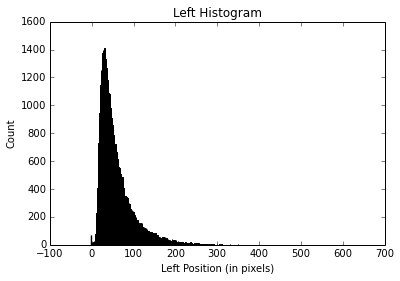

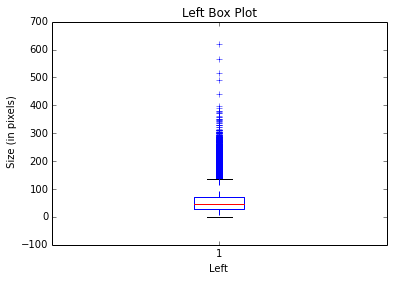

count    73257.000000
mean        58.397041
std         41.892324
min         -1.000000
25%         30.000000
50%         46.000000
75%         73.000000
max        618.000000
Name: Left, dtype: float64
median     46.0


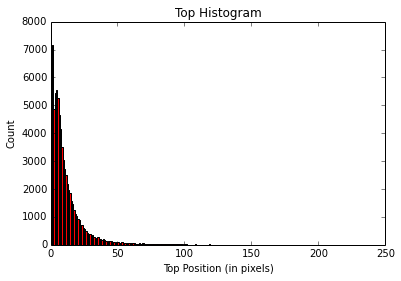

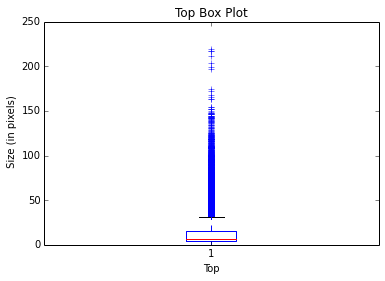

count    73257.000000
mean        11.879602
std         14.456877
min          0.000000
25%          4.000000
50%          7.000000
75%         15.000000
max        219.000000
Name: Top, dtype: float64
median     7.0


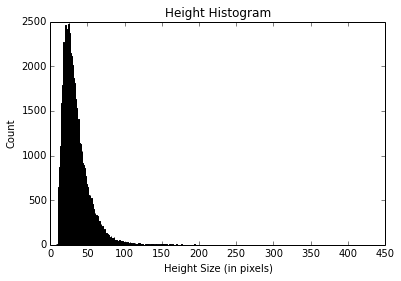

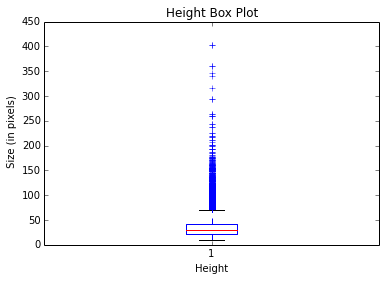

count    73257.000000
mean        33.861310
std         18.601294
min          9.000000
25%         21.000000
50%         29.000000
75%         41.000000
max        403.000000
Name: Height, dtype: float64
median     29.0


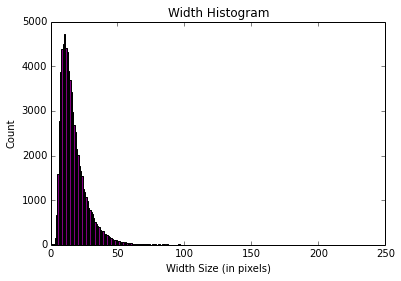

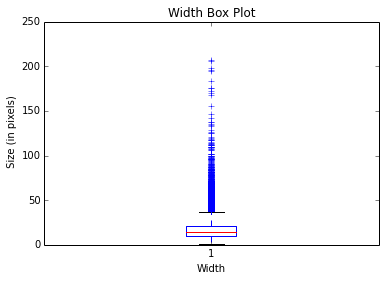

count    73257.000000
mean        16.650491
std         10.681429
min          1.000000
25%         10.000000
50%         14.000000
75%         21.000000
max        207.000000
Name: Width, dtype: float64
median     14.0
*********End - Training Data Visualisation*************


*********Start Test Data Visualisation*************


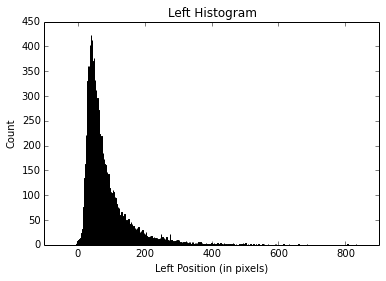

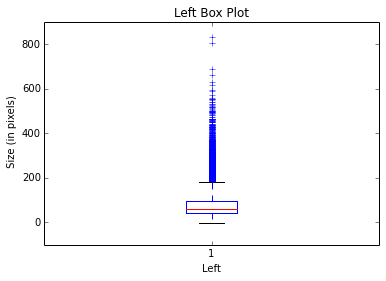

count    26032.000000
mean        80.639943
std         63.096593
min         -3.000000
25%         41.000000
50%         60.000000
75%         98.000000
max        832.000000
Name: Left, dtype: float64
median     60.0


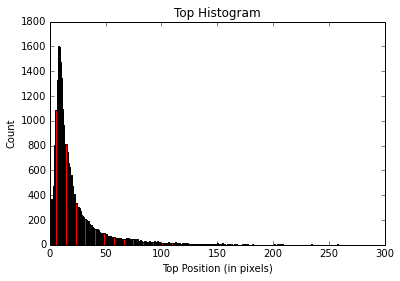

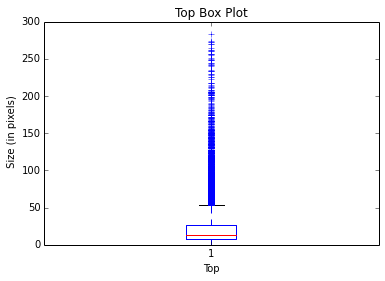

count    26032.000000
mean        22.619929
std         26.986472
min          0.000000
25%          8.000000
50%         13.000000
75%         26.000000
max        283.000000
Name: Top, dtype: float64
median     13.0


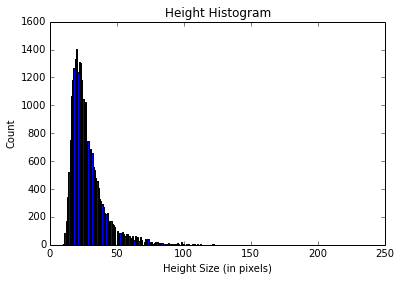

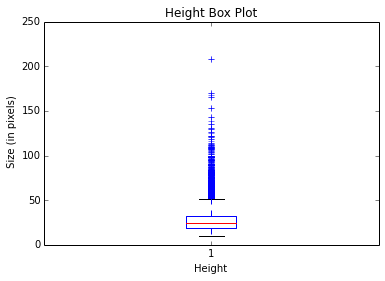

count    26032.000000
mean        27.961970
std         13.460746
min         10.000000
25%         19.000000
50%         24.000000
75%         32.000000
max        208.000000
Name: Height, dtype: float64
median     24.0


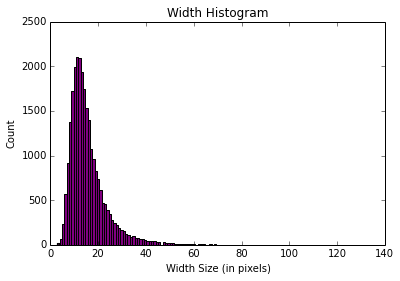

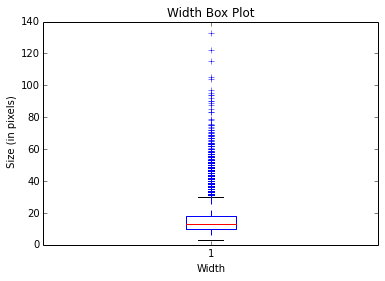

count    26032.000000
mean        15.516134
std          8.239447
min          3.000000
25%         10.000000
50%         13.000000
75%         18.000000
max        133.000000
Name: Width, dtype: float64
median     13.0
*********End Test Data Visualisation*************

End - Data Vizualisation...


In [5]:
print("Start - Data Vizualisation...")

"""Helpers"""
def show_histogram(data_frame, x_axis_name, x_axis_label, histogram_color_name):
    plt.hist(data_frame[x_axis_name], data_frame[x_axis_name].max(), facecolor=histogram_color_name)
    plt.title(x_axis_name + ' Histogram')
    plt.xlabel(x_axis_name + ' ' + x_axis_label +  ' (in pixels)')
    plt.ylabel('Count')
    plt.show()
    
def show_box_plot(data_frame, x_axis_name):
    plt.boxplot(data_frame[x_axis_name])
    plt.title(x_axis_name + ' Box Plot')
    plt.xlabel(x_axis_name + '')
    plt.ylabel(' Size (in pixels)')
    plt.show()
    
def get_statistics(data_frame,  statics_col_name, ):
    print(data_frame[statics_col_name].describe())
    left_median    = data_frame[statics_col_name].median()
    print ('median     ' + str(left_median))
        
"""Data Analysis"""
#view http://machinelearningmastery.com/quick-and-dirty-data-analysis-with-pandas/
main_directory             = 'svhn_data'

print ("*********Start - Training Data Visualisation*************")
train_raw_img_directory    = 'raw_train_csv'
train_raw_img_directory = main_directory + '/' + train_raw_img_directory

df = pd.read_csv(train_raw_img_directory + "/" + "train.csv")

#display graphs and staistics
show_histogram(df,'Left', 'Position', 'green')
show_box_plot(df,'Left')
get_statistics(df,'Left')

show_histogram(df,'Top', 'Position',  'red')
show_box_plot(df,'Top')
get_statistics(df, 'Top')

show_histogram(df,'Height', 'Size', 'blue')
show_box_plot(df,'Height')
get_statistics(df,'Height')

show_histogram(df,'Width', 'Size', 'purple')
show_box_plot(df,'Width')
get_statistics(df,'Width')
print ("*********End - Training Data Visualisation*************")
print ("")
print ("")
print ("*********Start Test Data Visualisation*************")
test_raw_img_directory    = 'raw_test_csv'
test_raw_img_directory = main_directory + '/' + test_raw_img_directory

df = pd.read_csv(test_raw_img_directory + "/" + "test.csv")

#display graphs and staistics
show_histogram(df,'Left', 'Position', 'green')
show_box_plot(df,'Left')
get_statistics(df,'Left')

show_histogram(df,'Top', 'Position',  'red')
show_box_plot(df,'Top')
get_statistics(df, 'Top')

show_histogram(df,'Height', 'Size', 'blue')
show_box_plot(df,'Height')
get_statistics(df,'Height')

show_histogram(df,'Width', 'Size', 'purple')
show_box_plot(df,'Width')
get_statistics(df,'Width')

print ("*********End Test Data Visualisation*************")

print("")
print("End - Data Vizualisation...")

In [ ]:
print("Start - Loading Massaged Trained and Test data ...")

"""Helpers"""
def remove_file(directory_path, file_name):
    file_full_path = directory_path + "/" + file_name
    if (os.path.isfile(file_full_path) == True):
        os.remove(file_full_path)            

def rearrange(x):
    n = x.shape[-1]
    out = np.zeros((n, 32, 32, 3), dtype=np.float32)
    for i in xrange(n):
        for j in xrange(3):
            out[i, :, :, j] = x[:, :, j, i]
    return out / 255

def flatten_keeping_order(list_of_lists):
    flattened  = np.asarray([val for sublist in list_of_lists for val in sublist]) 
    return flattened  

def hot_encode_labels(labels):
    n = len(labels)
    one_hot_labels = np.zeros((n, 10))
    for i in xrange(n):
        one_hot_labels[i, labels[i]] = 1
    return one_hot_labels.astype(np.float32)

def get_train_features_and_one_hot_labels(train_file_full_path):
    train = loadmat(train_file_full_path) #73257
    x_train = rearrange(train['X'])
    y_train_original = train['y']
    #Ytrain = train['y'].flatten() - 1
    y_train = flatten_keeping_order(train['y']) -1
    del train #remove ref to train (not the content)
    #Xtrain, Ytrain = shuffle(Xtrain, Ytrain)
    y_train_one_hot = hot_encode_labels(y_train)
    return x_train,y_train_original, y_train, y_train_one_hot 

def get_test_features_and_one_hot_labels(test_file_full_path):
    test = loadmat(test_file_full_path) 
    x_test  = rearrange(test['X'])
    #Ytest  = test['y'].flatten() - 1
    y_test  = flatten_keeping_order(test['y']) -1
    del test  #remove ref to test (not the content)
    y_test_one_hot  = hot_encode_labels(y_test)
    return x_test,y_test,y_test_one_hot 

"""Set Parameters"""
print ('CSV Set-up and Clean-up...')
print ('\t --> CSV files path set-up')
run_id = 'final'
print ('\t\t run_id:' + str(run_id))
params_settings_file_name = 'params_settings_' + str(run_id)
print ('\t\t params_settings:' + str(params_settings_file_name))
results_file_name = 'results_' + str(run_id)
print ('\t\t results_:' + str(results_file_name))
timings_file_name = 'timings_' + str(run_id)
print ('\t\t timings_:' + str(timings_file_name))
results_directory = 'svhn_data/results'
print ('\t\t results_directory:' + str(results_directory))

print ('\t --> Results Directory Clean-up')
remove_file(results_directory, params_settings_file_name )
remove_file(results_directory, results_file_name )
remove_file(results_directory, timings_file_name )

print ('Get the features and one hot labels...')
x_train,y_train_original, y_train, y_train_one_hot = get_train_features_and_one_hot_labels('svhn_data/train_32x32.mat')
x_test,y_test,y_test_one_hot = get_test_features_and_one_hot_labels('svhn_data/test_32x32.mat')

print("End - Loading Massaged Trained and Test data ...")

In [ ]:
print("Start - Setting Model Parameters ...")

"""Helpers"""
def create_empty_file(directory_path, file_name):
    create_directory(directory_path, False)
    file_full_path = directory_path + "/" + file_name
    if (os.path.isfile(file_full_path) == False):
        os.mknod(file_full_path)
    return file_full_path 

def print_and_store(directory_path,file_name, key, value):
    print ('\t\t ' + key + ':' + str(value))
    file_full_path = directory_path + "/" + file_name
    cols = ('Key', 'Value')
    if (os.path.isfile(file_full_path) == True):
        cols = ()
    write_to_csv(directory_path, file_name, cols, (str(key),str(value)), 'a')

def write_to_csv(directory_path, file_name, header_row, data_row, write_flag):    
    # write_flag = 'a' append to csv
    # write_flag = 'wt' replace and write
    file_full_path = create_empty_file(directory_path, file_name)
    f = open(file_full_path, write_flag)
    try:
        writer = csv.writer(f)
        if len(header_row)>0:
            writer.writerow(header_row)
        if len(data_row)>0:
            writer.writerow( data_row )
    finally:
        f.close()

"""Set Model Parameters """    
print ('\t --> Debug')
full_debug_info = False
print_and_store(results_directory, params_settings_file_name,'full_debug_info', full_debug_info)

print ('\t --> Train and test sizes params')
train_max_size = 5000#73257 #36628
print_and_store(results_directory, params_settings_file_name, 'train_max_size', train_max_size)
test_max_size = 1000#26032 #13016
print_and_store(results_directory, params_settings_file_name, 'test_max_size', test_max_size)

print ('\t --> Gradient descent params')
max_iter = 1
print_and_store(results_directory, params_settings_file_name, 'max_iter', max_iter)
batch_sz = 500 #train_max_size / 10 # for train_max_size = 1000 => batch_sz = 500
print_and_store(results_directory, params_settings_file_name, 'batch_sz', batch_sz)
test_batch_sz = 1000 #train_max_size / 10 # for train_max_size = 1000 => batch_sz = 500
print_and_store(results_directory, params_settings_file_name, 'test_batch_sz', test_batch_sz)
print_period = 10
print_and_store(results_directory, params_settings_file_name, 'print_period', print_period)

print ('\t --> Initial weights params')
m = 5000 # 500
print_and_store(results_directory, params_settings_file_name, 'M', m)
poolsz = (2, 2)
print_and_store(results_directory, params_settings_file_name, 'poolsz', poolsz)

print ('\t --> Conv params')
conv_strides = [1, 1, 1, 1]
print_and_store(results_directory, params_settings_file_name, 'conv_strides', conv_strides)
conv_padding = 'SAME'
print_and_store(results_directory, params_settings_file_name, 'conv_padding', conv_padding)

print ('\t --> Pool params')
pool_kernel_size = [1, 2, 2, 1]  
print_and_store(results_directory, params_settings_file_name, 'pool_kernel_size', pool_kernel_size)
pool_strides = [1, 2, 2, 1]
print_and_store(results_directory, params_settings_file_name, 'pool_strides', pool_strides)
pool_padding = 'SAME'
print_and_store(results_directory, params_settings_file_name, 'pool_padding', pool_padding)

print ('\t --> Conv path size, channels and feature maps params')
conv1_filter_width = 5
print_and_store(results_directory, params_settings_file_name, 'conv1_filter_width', conv1_filter_width)
conv1_filter_height = 5
print_and_store(results_directory, params_settings_file_name, 'conv1_filter_height', conv1_filter_height)
conv1_num_color_channels = 3
print_and_store(results_directory, params_settings_file_name, 'conv1_num_color_channels', conv1_num_color_channels)
conv1_num_feature_maps = 32
print_and_store(results_directory, params_settings_file_name, 'conv1_num_feature_maps', conv1_num_feature_maps)

conv2_filter_width = 5
print_and_store(results_directory, params_settings_file_name, 'conv2_filter_width', conv2_filter_width)
conv2_filter_height = 5
print_and_store(results_directory, params_settings_file_name, 'conv2_filter_height', conv2_filter_height)
conv2_num_color_channels = conv1_num_feature_maps
print_and_store(results_directory, params_settings_file_name, 'conv2_num_color_channels',conv2_num_color_channels)
conv2_num_feature_maps = 64
print_and_store(results_directory, params_settings_file_name, 'conv2_num_feature_maps',conv2_num_feature_maps)

conv22_filter_width = 5
print_and_store(results_directory, params_settings_file_name, 'conv22_filter_width',conv22_filter_width)
conv22_filter_height = 5
print_and_store(results_directory, params_settings_file_name, 'conv22_filter_height',conv22_filter_height)
conv22_num_color_channels = conv2_num_feature_maps
print_and_store(results_directory, params_settings_file_name, 'conv22_num_color_channels',conv22_num_color_channels)
conv22_num_feature_maps = 128
print_and_store(results_directory, params_settings_file_name, 'conv22_num_feature_maps',conv22_num_feature_maps)

print ('\t --> Dropout params')
drop_out_rate = 0.2 #the probability that a neuron's output is kept during dropout
print_and_store(results_directory, params_settings_file_name, 'keep_prob',drop_out_rate)

print ('\t --> RMSPropOptimizer params')
the_learning_rate = 0.0001 #A Tensor or a floating point value. The learning rate. 
print_and_store(results_directory, params_settings_file_name, 'the_learning_rate',the_learning_rate)
the_decay = 0.99 #Discounting factor for the history/coming gradient 
print_and_store(results_directory, params_settings_file_name, 'the_decay',the_decay)
the_momentum = 0.9 #A scalar tensor.
print_and_store(results_directory, params_settings_file_name, 'the_momentum',the_momentum)

print("End - Setting Model Parameters ...")

In [ ]:
print("Start - Initialising and Defining the Model...")

"""Helpers"""
def init_filter(shape, poolsz):
    w = np.random.randn(*shape) / np.sqrt(np.prod(shape[:-1]) + shape[-1]*np.prod(shape[:-2] / np.prod(poolsz)))
    return w.astype(np.float32)

def conv_shape_weight_biais_init(filter_width, filter_height, num_color_channels, num_feature_maps, poolsz):
    W_shape = (filter_width, filter_height, num_color_channels, num_feature_maps)
    W_init = init_filter(W_shape, poolsz)
    b_init = np.zeros(W_shape[-1], dtype=np.float32) # one bias per output feature map
    return W_shape, W_init,b_init

def init_weight_and_biais_variable(w_init, b_init):
    w = tf.Variable(w_init.astype(np.float32))
    b = tf.Variable(b_init.astype(np.float32))
    return w,b

def conv2d(X, W, b, conv_strides, conv_padding):
    conv = tf.nn.conv2d(X, W, strides=conv_strides, padding=conv_padding)
    conv = tf.nn.bias_add(conv, b)
    return conv

def relu(conv):
    return tf.nn.relu(conv)

def max_pool(conv, pool_kernel_size, pool_strides, pool_padding  ):
    max_pool = tf.nn.max_pool(conv, ksize=pool_kernel_size, strides=pool_strides, padding=pool_padding)
    return max_pool

"""Init and Define Model"""
print ('Parameters Validation...')
if (test_max_size >len(y_test_one_hot)):
    raise ValueError('test_max_size cannot be greater then the Ytest_one_hot lenght!')

print ('Resize the training and test sets...')
x_train = x_train[:train_max_size,]
x_test = x_test[:test_max_size,]
y_test = y_test[:test_max_size]
y_test_one_hot = y_test_one_hot[:test_max_size,]
y_train_one_hot = y_train_one_hot[:train_max_size,]
one_hot_len = len(y_test_one_hot)
one_hot_train_len = len(y_train_one_hot)

print ('Init placeholders and variables...')
k = len (y_test_one_hot.T)
n = x_train.shape[0]
n_batches = int(n / batch_sz)
# conv shape, weights and biais init
w1_shape, w1_init,b1_init = conv_shape_weight_biais_init (conv1_filter_width, conv1_filter_height, conv1_num_color_channels, conv1_num_feature_maps, poolsz)
w2_shape, w2_init,b2_init = conv_shape_weight_biais_init (conv2_filter_width, conv2_filter_height, conv2_num_color_channels, conv2_num_feature_maps, poolsz)
w22_shape, w22_init,b22_init = conv_shape_weight_biais_init (conv22_filter_width, conv22_filter_height, conv22_num_color_channels, conv22_num_feature_maps, poolsz)
# vanilla ANN weights init
w3_init = np.random.randn(w2_shape[-1]*8*4, m) / np.sqrt(w2_shape[-1]*8*4 + m) #3Layers 
#W3_init = np.random.randn(W2_shape[-1]*8*8, M) / np.sqrt(W2_shape[-1]*8*8 + M) #2Layers
b3_init = np.zeros(m, dtype=np.float32)
w4_init = np.random.randn(m, k) / np.sqrt(m + k)
b4_init = np.zeros(k, dtype=np.float32)
# define variables and expressions
# using None as the first shape element takes up too much RAM unfortunately
x = tf.placeholder(tf.float32, shape=(batch_sz, 32, 32, 3), name='x')
t = tf.placeholder(tf.float32, shape=(batch_sz, k), name='t')
w1, b1 = init_weight_and_biais_variable (w1_init, b1_init)
w2, b2 = init_weight_and_biais_variable (w2_init, b2_init)
w22, b22 = init_weight_and_biais_variable (w22_init, b22_init)
#W23, b23 = init_weight_and_biais_variable (W23_init, b23_init)
w3, b3 = init_weight_and_biais_variable (w3_init, b3_init)
w4, b4 = init_weight_and_biais_variable (w4_init, b4_init)

print ('Define convolution layers...')
conv1 =  conv2d (x, w1, b1, conv_strides, conv_padding)
conv1_relu =  relu(conv1)
max_pool_1 = max_pool (conv1_relu, pool_kernel_size, pool_strides, pool_padding)              

conv2 =  conv2d (max_pool_1, w2, b2, conv_strides, conv_padding)
conv2_relu = relu(conv2)
max_pool_2 = max_pool (conv2_relu, pool_kernel_size, pool_strides, pool_padding)              
max_pool_2_shape = max_pool_2.get_shape().as_list()
max_pool_2_reshape = tf.reshape(max_pool_2, [max_pool_2_shape[0], np.prod(max_pool_2_shape[1:])])

conv22 =  conv2d (max_pool_2, w22, b22, conv_strides, conv_padding) #conv2 
conv22_relu = relu(conv22) #conv2_relu
max_pool_22 = max_pool (conv22_relu, pool_kernel_size, pool_strides, pool_padding) #max_pool_2              
max_pool_22_shape = max_pool_22.get_shape().as_list()
max_pool_22_reshape = tf.reshape(max_pool_22, [max_pool_22_shape[0], np.prod(max_pool_22_shape[1:])])

conv_final = tf.matmul(max_pool_22_reshape, w3) + b3 

keep_prob = tf.placeholder(tf.float32)
drop_out = tf.nn.dropout(conv_final, keep_prob)

y_prediction = tf.nn.softmax(tf.matmul(drop_out, w4) + b4)

print("End - Initialising and Defining the Model...")

In [ ]:
print("Start - Training and Measuring Model Accuracy...")

"""Helpers"""
def error_rate(p, t):
    return np.mean(p != t)

def print_start_training_info (iteration_id, batch_id):
    print ("\t Start Training...")
    print ("\t Iteration Id: ", iteration_id)
    print ("\t Batch Id:", batch_id)

def print_info (run_type,results_directory, timings_file_name, iteration_id, batch_id, start_index, err, start_time, full_debug_info):
    err_rate = round(100.0*err,2)
    accuracy_rate = round(100.0*(1.0-err),2)
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    start = start_time.strftime("%Y-%m-%d %H:%M:%S")
    elapsed = datetime.now() - start_time
    if full_debug_info == True:
        print ("\t ********Sample Test Run*************")
        print ("\t Run Type: ", run_type)
        print ("\t Iteration Id: ", iteration_id)
        print ("\t Batch Id:", batch_id)
        print ("\t Test Start Index: ", start_index)
        print ("\t Error(%): ", err_rate)
        print ("\t Accuracy(%):" , accuracy_rate)
        print ("\t Current time - Batch Calc:", now)
        print ("\t Elapsed time - Batch Calc:", elapsed)
    write_to_csv(results_directory, results_file_name, (), (run_type,iteration_id,batch_id,start_index, err_rate, accuracy_rate, start, now, elapsed ), 'a')

def print_loss_info (run_type,results_directory, timings_file_name, iteration_id, batch_id, loss, start_time, full_debug_info):
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    start = start_time.strftime("%Y-%m-%d %H:%M:%S")
    elapsed = datetime.now() - start_time
    if full_debug_info == True:
        print ("\t ********Sample Test Run*************")
        print ("\t Run Type: ", run_type)
        print ("\t Iteration Id: ", iteration_id)
        print ("\t Batch Id:", batch_id)
        print ("\t Loss: ", err_rate)
        print ("\t Current time - Batch Calc:", now)
        print ("\t Elapsed time - Batch Calc:", elapsed)
    write_to_csv(results_directory, results_file_name, (), (run_type,iteration_id,batch_id,-1, loss, -1, start, now, elapsed ), 'a')

def get_predictions(run_type, batch_sz, batch_sz_1, features, labels, labels_one_hot, predict_op_param):
    start_index = 0
    end_index = 0
    one_hot_len = len(labels_one_hot)
    while (start_index+batch_sz_1) <= one_hot_len:
        print ("one_hot_len: "+ str(one_hot_len))
        #due to RAM limitations we need to have a fixed size input
        #so as a result, we have this ugly total cost and prediction computation
        #we also need to have a fixed size test iput and then we average.
        end_index = start_index+batch_sz_1
        features_sample = features[start_index:end_index]
        labels_sample = labels[start_index:end_index]
        labels_one_hot_sample = labels_one_hot[start_index:end_index,]
        test_cost = 0
        prediction = np.zeros(len(features_sample))
        for kk in xrange(int(len(features_sample) / batch_sz)):
            features_batch = features_sample[kk*batch_sz:(kk*batch_sz + batch_sz),]
            labels_batch = labels_one_hot_sample[kk*batch_sz:(kk*batch_sz + batch_sz),]
            prediction[kk*batch_sz:(kk*batch_sz + batch_sz)] = session.run(predict_op_param, feed_dict={x: features_batch, keep_prob: 1.0})
        err = error_rate(prediction, labels_sample) #error calculation
        print_info(run_type, results_directory, results_file_name, i,j,start_index, err,batch_start_time, full_debug_info) #print sample test info
        start_index = start_index + batch_sz_1 #reset the start_index
    return prediction, start_index
    
"""Training"""
#print the timing information on training completion
train_start_time = datetime.now()
train_start_time_display = train_start_time.strftime("%Y-%m-%d %H:%M:%S")
print ("\t Start time - " + train_start_time_display)
write_to_csv(results_directory, timings_file_name, ('Start_Time', 'End_Time'), (train_start_time_display, ''), 'a')
write_to_csv(results_directory, results_file_name, ('Type','Iteration_Id', 'Batch_Id','Test_Start_Index','Error_%','Accuracy_%','Start_Time', 'Current_Time','Elapsed_Time'), ( ), 'a')

#define the cost function that needs minimising during training 
loss_op = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(y_prediction, t))
train_op = tf.train.RMSPropOptimizer(learning_rate=the_learning_rate, decay=the_decay, momentum=the_momentum).minimize(loss_op)
#define the prediction function
predict_op = tf.argmax(y_prediction, 1)

init = tf.initialize_all_variables()
session = tf.Session()
session.run(init)

print("\t drop_out_rate:" + str(drop_out_rate))
for i in xrange(max_iter):
    print ("\t Nb of batches: "+ str(n_batches))
    for j in xrange(n_batches):
        batch_start_time = datetime.now()
        x_batch = x_train[j*batch_sz:(j*batch_sz + batch_sz),]
        y_batch = y_train_one_hot[j*batch_sz:(j*batch_sz + batch_sz),]
        if len(x_batch) == batch_sz:
            res = session.run([train_op,loss_op], feed_dict={x: x_batch, t: y_batch, keep_prob: drop_out_rate})
            loss = res[1]
            if j % print_period == 0:
                #print the iteration and batch id
                print_start_training_info(i,j) 
                #store the loss info        
                print_loss_info("Loss", results_directory, results_file_name, i,j,loss,batch_start_time, full_debug_info) 
                #calc train predictions and store training accuracy
                prediction_train, train_start_index = get_predictions("Train", batch_sz, batch_sz, x_train, y_train, y_train_one_hot, predict_op)
                #calc test predictions and store test accuracy
                prediction, test_start_index = get_predictions("Test", batch_sz, test_batch_sz, x_test, y_test, y_test_one_hot, predict_op)
    
#print the timing information on training completion
train_end_time = datetime.now()
train_end_time_display = train_end_time.strftime("%Y-%m-%d %H:%M:%S")
print ("\t End time - " + train_end_time_display)
write_to_csv(results_directory, timings_file_name, (), ('', train_end_time_display), 'a')

print("End - Training and Measuring Model Accuracy...")

Start - Learning Process Analysis ...

******************************************************************************************
************************base_case/results_base_case******************************************
******************************************************************************************

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Statistics (Training Accuracy) >>>>>>>>>>>>>>>>>>>>>>>>>>>
Training Aggregated Data: <bound method DataFrame.describe of     Accuracy_%
0    22.809406
1    39.355160
2    49.510187
3    56.493607
4    66.872059
5    73.815708
6    74.989680
7    75.195342
8    78.924566
9    82.977900
10   83.345297
11   85.438995
12   89.862192
13   90.341005
14   90.157260
15   90.081644
16   90.798447
17   90.559543
18   90.355525
19   90.606393>
Min Training Accuracy_%: 22.8094063927
Median Training Accuracy_%: 83.1615981735
Max Training Accuracy_%: 90.7984474886

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Statistics (Test Accuracy) >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


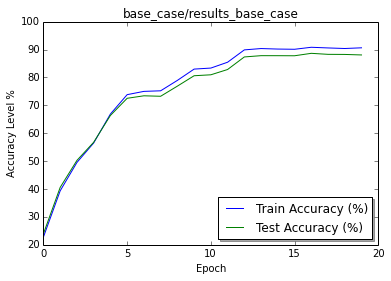

******************************************************************************************

******************************************************************************************
************************lr/results_lr_0.001******************************************
******************************************************************************************

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Statistics (Training Accuracy) >>>>>>>>>>>>>>>>>>>>>>>>>>>
Training Aggregated Data: <bound method DataFrame.describe of     Accuracy_%
0    18.924566
1    18.928735
2    18.928767
3    18.928767
4    18.927298
5    18.928767
6    18.928767
7    18.928767
8    18.928767
9    18.928767
10   18.928767
11   18.928767
12   18.928767
13   18.928767
14   18.928767
15   18.928767
16   18.928767
17   18.928767
18   18.928767
19   18.928767>
Min Training Accuracy_%: 18.92456621
Median Training Accuracy_%: 18.9287671233
Max Training Accuracy_%: 18.9287671233

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Statistics (Test 

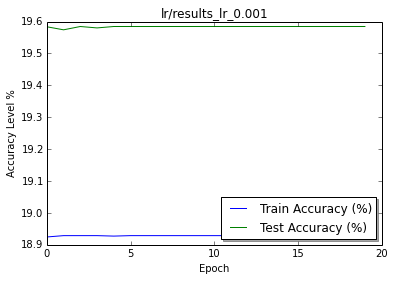

******************************************************************************************

******************************************************************************************
************************lr/results_lr_0.01******************************************
******************************************************************************************

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Statistics (Training Accuracy) >>>>>>>>>>>>>>>>>>>>>>>>>>>
Training Aggregated Data: <bound method DataFrame.describe of     Accuracy_%
0    18.929035
1    18.928767
2    18.928767
3    18.929616
4    18.928767
5    18.928767
6    18.928767
7    18.928767
8    18.928767
9    18.928767
10   18.928767
11   18.928767
12   18.928767
13   18.928767
14   18.928767
15   18.928767
16   18.928767
17   18.928767
18   18.928767
19   18.928767>
Min Training Accuracy_%: 18.9287671233
Median Training Accuracy_%: 18.9287671233
Max Training Accuracy_%: 18.9296160878

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Statistics (Test

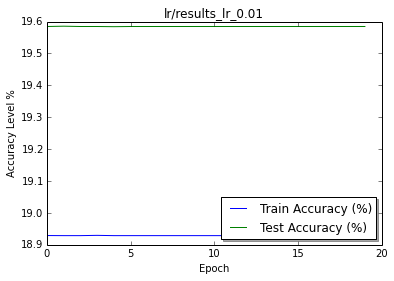

******************************************************************************************

******************************************************************************************
************************lr/results_lr_0.5******************************************
******************************************************************************************

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Statistics (Training Accuracy) >>>>>>>>>>>>>>>>>>>>>>>>>>>
Training Aggregated Data: <bound method DataFrame.describe of     Accuracy_%
0    18.928767
1    18.928767
2    18.928767
3    18.928767
4    18.928767
5    18.928767
6    18.928767
7    18.928767
8    18.928767
9    18.928767
10   18.928767
11   18.928767
12   18.928767
13   18.928767
14   18.928767
15   18.928767
16   18.928767
17   18.928767
18   18.928767
19   18.928767
20   18.914393>
Min Training Accuracy_%: 18.9143925234
Median Training Accuracy_%: 18.9287671233
Max Training Accuracy_%: 18.9287671233

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> St

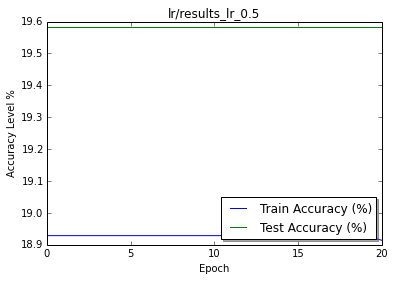

******************************************************************************************

******************************************************************************************
************************dc/results_dc_0.5******************************************
******************************************************************************************

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Statistics (Training Accuracy) >>>>>>>>>>>>>>>>>>>>>>>>>>>
Training Aggregated Data: <bound method DataFrame.describe of     Accuracy_%
0    36.468858
1    57.698630
2    58.586575
3    59.045388
4    59.089438
5    59.557991
6    59.508037
7    59.347671
8    59.780091
9    59.543288
10   59.730502
11   59.156895
12   59.079087
13   59.518447
14   59.524566
15   59.401918
16   59.635890
17   59.021461
18   58.693059
19   59.175708>
Min Training Accuracy_%: 36.4688584475
Median Training Accuracy_%: 59.2616894977
Max Training Accuracy_%: 59.7800913242

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Statistics (Test 

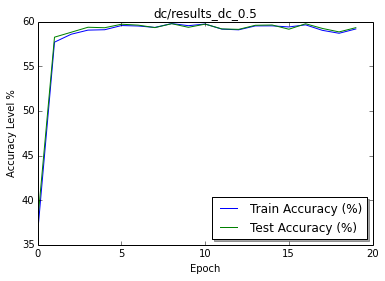

******************************************************************************************

******************************************************************************************
************************dc/results_dc_0.9******************************************
******************************************************************************************

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Statistics (Training Accuracy) >>>>>>>>>>>>>>>>>>>>>>>>>>>
Training Aggregated Data: <bound method DataFrame.describe of     Accuracy_%
0    28.924292
1    57.309648
2    65.444922
3    70.472968
4    72.222922
5    76.146484
6    76.501096
7    76.644475
8    81.572329
9    82.183105
10   82.587123
11   82.489224
12   82.588767
13   82.320731
14   82.144566
15   81.829315
16   82.280457
17   82.517169
18   82.494064
19   82.571872>
Min Training Accuracy_%: 28.9242922374
Median Training Accuracy_%: 81.9869406393
Max Training Accuracy_%: 82.5887671233

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Statistics (Test 

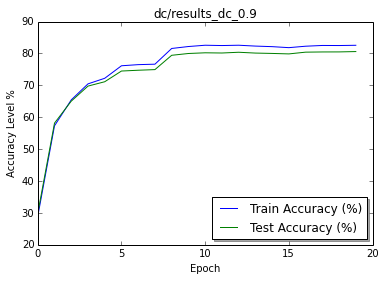

******************************************************************************************

******************************************************************************************
************************do/results_do_0.2******************************************
******************************************************************************************

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Statistics (Training Accuracy) >>>>>>>>>>>>>>>>>>>>>>>>>>>
Training Aggregated Data: <bound method DataFrame.describe of     Accuracy_%
0    22.680274
1    41.748858
2    51.921187
3    68.509548
4    74.758885
5    80.727945
6    82.020365
7    86.218995
8    89.926393
9    90.575251
10   90.993425
11   90.992329
12   91.063927
13   91.365571
14   90.972694
15   91.628128
16   91.207306
17   91.413516
18   91.425936
19   91.550868>
Min Training Accuracy_%: 22.6802739726
Median Training Accuracy_%: 90.7739726027
Max Training Accuracy_%: 91.6281278539

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Statistics (Test 

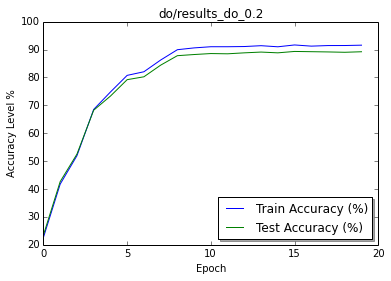

******************************************************************************************

******************************************************************************************
************************do/results_do_0.7******************************************
******************************************************************************************

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Statistics (Training Accuracy) >>>>>>>>>>>>>>>>>>>>>>>>>>>
Training Aggregated Data: <bound method DataFrame.describe of     Accuracy_%
0    21.575799
1    39.282450
2    49.564840
3    60.537871
4    70.201005
5    79.401187
6    81.257991
7    81.544384
8    81.574247
9    82.067671
10   81.317900
11   81.884566
12   81.603562
13   85.006027
14   88.552146
15   89.353790
16   88.544840
17   88.603927
18   88.868950
19   88.718630>
Min Training Accuracy_%: 21.5757990868
Median Training Accuracy_%: 81.5889041096
Max Training Accuracy_%: 89.3537899543

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Statistics (Test 

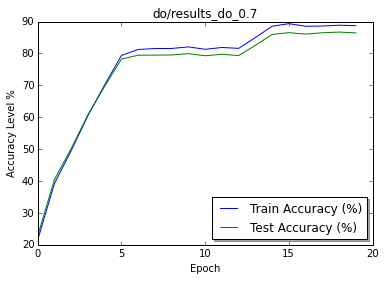

******************************************************************************************

******************************************************************************************
************************fltr/results_fltr_2******************************************
******************************************************************************************

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Statistics (Training Accuracy) >>>>>>>>>>>>>>>>>>>>>>>>>>>
Training Aggregated Data: <bound method DataFrame.describe of     Accuracy_%
0    20.335708
1    31.744932
2    41.973059
3    49.071416
4    50.983836
5    55.041096
6    55.916256
7    56.277443
8    56.427489
9    56.550137
10   56.831050
11   60.946484
12   61.753516
13   61.863836
14   62.091781
15   62.215890
16   62.609863
17   62.529680
18   62.590320
19   62.893881>
Min Training Accuracy_%: 20.3357077626
Median Training Accuracy_%: 56.6905936073
Max Training Accuracy_%: 62.8938812785

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Statistics (Tes

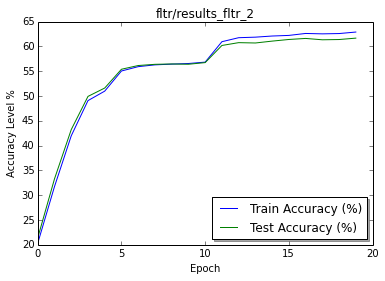

******************************************************************************************

******************************************************************************************
************************cnn/results_ccn_2_layers******************************************
******************************************************************************************

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Statistics (Training Accuracy) >>>>>>>>>>>>>>>>>>>>>>>>>>>
Training Aggregated Data: <bound method DataFrame.describe of     Accuracy_%
0    24.432892
1    40.549498
2    48.766590
3    50.831598
4    57.413431
5    63.684292
6    68.342283
7    69.042922
8    69.369132
9    69.512511
10   69.574521
11   69.637169
12   69.694155
13   73.046027
14   74.625023
15   74.707123
16   74.819269
17   74.834703
18   74.924566
19   74.850137>
Min Training Accuracy_%: 24.4328917314
Median Training Accuracy_%: 69.5435159817
Max Training Accuracy_%: 74.92456621

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Statistics (

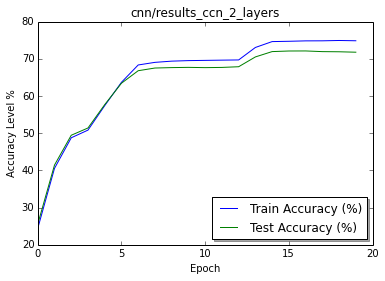

******************************************************************************************

******************************************************************************************
************************cnn/results_ccn_4_layers******************************************
******************************************************************************************

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Statistics (Training Accuracy) >>>>>>>>>>>>>>>>>>>>>>>>>>>
Training Aggregated Data: <bound method DataFrame.describe of     Accuracy_%
0    19.955941
1    35.896621
2    48.305619
3    67.267245
4    79.267671
5    81.113151
6    81.875616
7    87.518082
8    89.785388
9    90.330228
10   90.780731
11   90.253973
12   90.028128
13   90.132146
14   89.724110
15   89.914521
16   89.107580
17   88.204749
18   87.277717
19   87.985388>
Min Training Accuracy_%: 19.9559414991
Median Training Accuracy_%: 88.0950684932
Max Training Accuracy_%: 90.7807305936

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Statistics

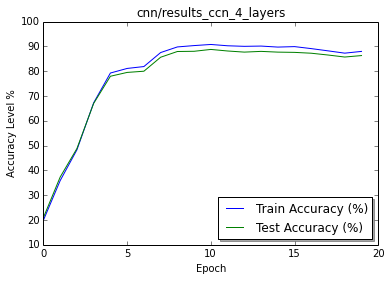

******************************************************************************************


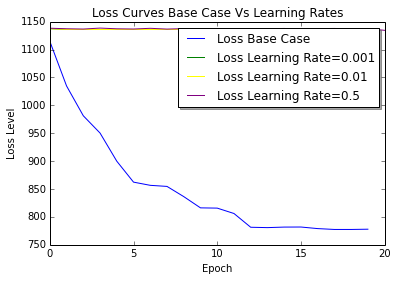

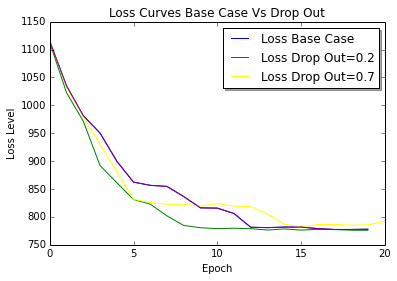

An unexpected error occured File svhn_data/results/do/results_dc_0.5 does not exist
End - Learning Process Analysis ...


In [13]:
print("Start - Learning Process Analysis ...")

main_directory      = 'svhn_data'
results_directory   = 'results'
    
results_directory = main_directory + '/' + results_directory 


def show_train_validation_accuracy( result_file_name, start_time_idx, end_time_idx,):
    print ("")
    print ("******************************************************************************************")
    print ("************************" + result_file_name + "******************************************")
    print ("******************************************************************************************")
    print ("")
    df = pd.read_csv(results_directory + "/" + result_file_name)
    start_time= datetime.strptime(df.loc[start_time_idx, 'Start_Time'],"%Y-%m-%d %H:%M:%S")
    end_time= datetime.strptime(df.loc[end_time_idx, 'Current_Time'], "%Y-%m-%d %H:%M:%S")
    time_to_completion = end_time - start_time
    train_df = df.loc[df['Type'] == 'Train']
    train_accuracy_avg = train_df.groupby('Iteration_Id',as_index=False)['Accuracy_%'].mean()
    test_df = df.loc[df['Type'] == 'Test']
    test_accuracy_avg = test_df.groupby('Iteration_Id',as_index=False)['Accuracy_%'].mean()
    print (">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Statistics (Training Accuracy) >>>>>>>>>>>>>>>>>>>>>>>>>>>")
    print ("Training Aggregated Data: " + str(train_accuracy_avg.ix[:,1:3].describe))
    print ("Min Training Accuracy_%: " +  str(train_accuracy_avg['Accuracy_%'].min()))
    print ("Median Training Accuracy_%: " +  str(train_accuracy_avg['Accuracy_%'].median()))
    print ("Max Training Accuracy_%: " +  str(train_accuracy_avg['Accuracy_%'].max()))
    print ("")
    print (">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Statistics (Test Accuracy) >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    print ("Test Aggregated Data: " + str(test_accuracy_avg.ix[:,1:3].describe))
    print ("Min Test Accuracy_%: " +  str(test_accuracy_avg['Accuracy_%'].min()))
    print ("Median Test Accuracy_%: " +  str(test_accuracy_avg['Accuracy_%'].median()))
    print ("Max Test Accuracy_%: " +  str(test_accuracy_avg['Accuracy_%'].max()))
    print ("")
    print (">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Time to Completion>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    
    print ("Time to completion: (start:" + str(start_time) + " - end:" + str(end_time) + ") -> " +  str(time_to_completion))
    
    print (">>>>>>>>>>>>>>>>>>>>>>>>>>> Graph Training Vs Test Accuracy >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    plt.title(result_file_name)
    plt.ylabel('Accuracy Level %')
    plt.xlabel('Epoch')
    plt.gca().set_color_cycle(['blue','green'])
    plt.plot(train_accuracy_avg['Iteration_Id'], train_accuracy_avg['Accuracy_%'], label='Train Accuracy (%)')
    plt.plot(test_accuracy_avg['Iteration_Id'], test_accuracy_avg['Accuracy_%'], label='Test Accuracy (%)')
    plt.legend(loc="lower right", shadow=True)
    plt.show()
    print ("******************************************************************************************")
    
def show_loss(title, label_base_case, df_base_case,
                     label_sim_1, df_sim1, 
                     label_sim_2, df_sim2, 
                     label_sim_3, df_sim3):
    loss_avg_base_case = df_base_case.loc[df_base_case['Type'] == 'Loss'].groupby('Iteration_Id',as_index=False)['Error_%'].mean()
    loss_avg_sim_1 = df_sim1.loc[df_sim1['Type'] == 'Loss'].groupby('Iteration_Id',as_index=False)['Error_%'].mean()
    loss_avg_sim_2 = df_sim2.loc[df_sim2['Type'] == 'Loss'].groupby('Iteration_Id',as_index=False)['Error_%'].mean()
    loss_avg_sim_3 = df_sim3.loc[df_sim3['Type'] == 'Loss'].groupby('Iteration_Id',as_index=False)['Error_%'].mean()
    plt.title(title)
    plt.ylabel('Loss Level')
    plt.xlabel('Epoch')
    plt.gca().set_color_cycle(['blue','green','yellow', 'purple'])
    #add more graph below
    plt.plot(loss_avg_base_case['Iteration_Id'], loss_avg_base_case['Error_%'], label=label_base_case)
    plt.plot(loss_avg_sim_1['Iteration_Id'], loss_avg_sim_1['Error_%'], label=label_sim_1)
    plt.plot(loss_avg_sim_2['Iteration_Id'], loss_avg_sim_2['Error_%'], label=label_sim_2)
    plt.plot(loss_avg_sim_3['Iteration_Id'], loss_avg_sim_3['Error_%'], label=label_sim_3)
    plt.legend(loc="upper right", shadow=True)
    plt.show()

try:
    #display train vs test accuracy graphs
    #base
    show_train_validation_accuracy("base_case/results_base_case", 0,51877)
    #lr simulation
    show_train_validation_accuracy("lr/results_lr_0.001", 0,51877)
    show_train_validation_accuracy("lr/results_lr_0.01", 0,51877)
    show_train_validation_accuracy("lr/results_lr_0.5", 0,51877)
    #dc simulation
    show_train_validation_accuracy("dc/results_dc_0.5", 0,51877)
    show_train_validation_accuracy("dc/results_dc_0.9", 0,51877)
    #do simulation
    show_train_validation_accuracy("do/results_do_0.2", 0,51877)
    show_train_validation_accuracy("do/results_do_0.7", 0,51877)
    #fltr simulation
    show_train_validation_accuracy("fltr/results_fltr_2", 0,51877)
    #cnn simulation
    show_train_validation_accuracy("cnn/results_ccn_2_layers", 0,51891)
    show_train_validation_accuracy("cnn/results_ccn_4_layers", 0,51894)
    #show_train_validation_accuracy("results_M5000_3CL_itr100_train_36628_test_13016_DO_09")
    #add more
    
    #display loss graphs
    df_base_case = pd.read_csv(results_directory + "/" + "base_case/results_base_case")
    df_lr_0_001 = pd.read_csv(results_directory + "/" + "lr/results_lr_0.001")
    df_lr_0_01 = pd.read_csv(results_directory + "/" + "lr/results_lr_0.01")
    df_lr_0_5 = pd.read_csv(results_directory + "/" + "lr/results_lr_0.5")
    show_loss(  "Loss Curves Base Case Vs Learning Rates", 
                'Loss Base Case',
                df_base_case, 
                'Loss Learning Rate=0.001',
                df_lr_0_001,
                'Loss Learning Rate=0.01',
                df_lr_0_01,
                'Loss Learning Rate=0.5',
                df_lr_0_5)

    df_do_0_2 = pd.read_csv(results_directory + "/" + "do/results_do_0.2")
    df_do_0_7 = pd.read_csv(results_directory + "/" + "do/results_do_0.7")
    show_loss(  "Loss Curves Base Case Vs Drop Out", 
                'Loss Base Case',
                df_base_case, 
                'Loss Drop Out=0.2',
                df_do_0_2,
                'Loss Drop Out=0.7',
                df_do_0_7,
                '', #dummy 
                df_base_case)  #dummy
    
    df_dc_0_5 = pd.read_csv(results_directory + "/" + "do/results_dc_0.5")
    df_dc_0_9 = pd.read_csv(results_directory + "/" + "do/results_dc_0.9")
    show_loss(  "Loss Curves Base Case Vs Drop Out", 
                'Loss Base Case',
                df_base_case, 
                'Loss Drop Out=0.5',
                df_dc_0_5,
                'Loss Drop Out=0.9',
                df_dc_0_9,
                '', #dummy 
                df_base_case)  #dummy
    
    df_cnn_2 = pd.read_csv(results_directory + "/" + "cnn/results_ccn_2_layers")
    df_cnn_4 = pd.read_csv(results_directory + "/" + "cnn/results_ccn_4_layers")
    show_loss(  "Loss Curves Base Case Vs Different CNN Implmentations", 
                'Loss Base Case',
                df_base_case, 
                'Loss CNN layers=2',
                df_cnn_2,
                'Loss CNN layers=4',
                df_cnn_4,
                '', #dummy
                df_base_case)#dummy

except Exception as e:
        print("An unexpected error occured", e)

print("End - Learning Process Analysis ...")


In [ ]:
print("Start - Number Prediction Visual Representation...")

"""Helpers"""
# maxCount = the max number of rows to show image vs true label vs predicted label for
# true_labels =  the list of true labels (labels attached against an picture from the source dataset)
# predicted_labels =  the list of predicted labels (i.e. labels guessed by the model)
# predicted_labels_offset =  An offset on the predicted labels, as they have been reduced by one during the flattening exericse to enable the one-hot label generation
def visual_representation(maxCount,true_labels, predicted_labels,predicted_labels_offset = 1):
    main_directory             = 'svhn_data'
    train_raw_csv_directory    = 'raw_train_csv'
    train_csv                  = 'train.csv'
    train_raw_img_directory    = 'raw_train_img'
    
    train_raw_csv_directory = main_directory + '/' + train_raw_csv_directory
    train_raw_img_directory = main_directory + '/' + train_raw_img_directory
    
    try:
        #open the csv file
        csv_reader = open(train_raw_csv_directory + '/'+ train_csv, 'r')
        lines = csv_reader.readlines()
        i = 0
        temp_image_name = "temp";
        image_name = "";
        match = "no match"
        count_match = 0.0
        total = 0.0
        #display image name /labels and result
        for index in range(len(predicted_labels)):
            line_splits = lines[index+1].split(",")
            image_name = line_splits[0] #first is the image name
            true_label = line_splits[1] #second is the true label
            predicted_label = str(int(predicted_labels[index]) + predicted_labels_offset)#thirst is the predicted label
            
            #display image and description headers    
            if (temp_image_name != image_name):
                if(index > 0):
                    success_rate = "%0.2f" % (100.0 * (count_match/total))
                    print ("Success Rate: " + str(success_rate) + "%")
                    total = 0.0
                    count_match = 0.0
                from IPython.display import display, Image #required else it breaks...
                img= Image(filename=train_raw_img_directory + "/" + image_name) 
                print("")
                print("***************************************************************************************************")
                display(img)
                print("Idx \t Image Name \t True Label \t Predicted Label \t Result")
            
            #count digit matches and total number of digits per image
            if (true_label == predicted_label):
                match = "match"
                count_match = count_match + 1.0
            total = total + 1.0
            
            #display description
            print(str(index) + " \t " + image_name + " \t\t " + true_label + " \t\t " + str(predicted_label) + " \t\t\t " + match )
            
            #reset params
            match = "no match"
            i = i + 1
            temp_image_name = image_name
            if (i == maxCount):
                break;
    except Exception as e:
        print("An unexpected error occured", e)
    
print("End Number Prediction Visual Representation...")    

"""View Results"""
visual_representation(500, y_train, prediction_train,1 )